This is the model implemented from [this paper](https://www.pnas.org/content/pnas/105/40/15346.full.pdf).

In [1]:
using AgentBasedModels
using GLMakie
#import GLMakie.GeometryBasics as gm
using Random
using Distributions
using CUDA

using BenchmarkTools

# First model: Interaction model

In [113]:
model = @agent(2,
            [vx,vy,theta,ω,d,l,m,I,Fx,Fy,W]::Local, #Local parameters
            [kn,γn,γt,μcc,μcw,β,βω]::Global,        #Global parameters
            contact::Identity,

            UpdateInteraction = begin
                #Compute distance between centers of mass
                dAux = sqrt((x.i-x.j)^2+(y.i-y.j)^2)
                if dAux > 0 && dAux < (l.i+l.j)/2
                    if abs(theta.i-theta.j)>0.001 #If not aligned
                        #Compute intersecting point virtual spheres
                        cxAux = (x.i-x.j)
                        cyAux = (y.i-y.j)
                        normAux = cos(theta.i)*sin(theta.j)-sin(theta.i)*cos(theta.j)
                        scaleAux = (-sin(theta.j)*cxAux+cos(theta.j)*cyAux)/normAux
                        pxAux = scaleAux*cos(theta.i)+x.i
                        pyAux = scaleAux*sin(theta.i)+y.i
                        
                        #Compute distance from mass center
                        di = sqrt((x.i-pxAux)^2+(y.i-pyAux)^2)
                        if di <= l.i/2 #Cross point in cylinder
                            xiAux = 0.999*scaleAux*cos(theta.i)+x.i
                            yiAux = 0.999*scaleAux*sin(theta.i)+y.i
                            scaleAux = (-sin(theta.i)*cxAux+cos(theta.i)*cyAux)/normAux
                            xjAux = 0.999*scaleAux*cos(theta.j)+x.j
                            yjAux = 0.999*scaleAux*sin(theta.j)+y.j
                        else #Cross point outside cylinder
                            xiAux = l.i/2*cos(theta.i)+x.i
                            yiAux = l.i/2*sin(theta.i)+y.i
                            xjAux = l.j/2*cos(theta.j)+x.j
                            yjAux = l.j/2*sin(theta.j)+y.j
                        end
                    else #If aligned
                        xiAux = -0.49*(x.i-x.j)*cos(theta.i)+x.i
                        yiAux = -0.49*(y.i-y.j)*sin(theta.i)+y.i
                        xjAux = -0.49*(x.j-x.i)*cos(theta.j)+x.j
                        yjAux = -0.49*(y.j-y.i)*sin(theta.j)+y.j         
                    end

                    #Compute distance between virtual spheres
                    rij = sqrt((xiAux-xjAux)^2 +(yiAux-yjAux)^2)
                    if rij > 0 && rij < d.i #If it is smaller than a diameter
                        #Compute auxiliar
                        δAux = d.i - rij
                        MeAux = m.i/2
                        #Compute interaction
                        nijx = (xiAux-xjAux)/rij
                        nijy = (yiAux-yjAux)/rij
                        vijx = (vx.i-vx.j)
                        vijy = (vy.i-vy.j)
                        #Compute inner product
                        vnAux = nijx*vijx+nijy*vijy
                        #Compute normal and tangential forces
                        FnAux = kn*δAux^1.5-γn*MeAux*δAux*vnAux
                        FtAux = -min(γt*MeAux*δAux^.5,μcc*FnAux)
                        #Append to interaction forces
                        Fijx = FnAux*nijx + FtAux*(vijx-vnAux*nijx)
                        Fijy = FnAux*nijy + FtAux*(vijy-vnAux*nijx)
                        Fx.i += Fijx
                        Fy.i += Fijy
                        #Append radial forces
                        W.i += (xiAux-x.i)*Fijy - (yiAux-y.i)*Fijx
                    end
                end
            end,

            Equation = begin
                d(x) = vx*dt
                d(y) = vy*dt
                d(vx) = -β*vx*dt+Fx/m*dt
                d(vy) = -β*vy*dt+Fy/m*dt
                d(ω) = W/(m*(d+l)^2/12+m*d^2)*dt-βω*ω*dt
                d(theta) = ω*dt
            end,

            UpdateLocal = begin #Bound cells
                if theta < -π/2
                    theta += π
                elseif theta > π/2
                    theta -= π
                end
            end
    );

model = compile(model,integrator="Euler",platform="cpu");
#model.program

## Checking mechanics of two bacterial cells

In [198]:
com = Community(model,N=2);

com.kn = 1.
com.γn = 1.
com.γt = 1.
com.μcc = 0.1
com.μcw = 0.8
com.β = 5.
com.βω = 5.

com.m .= 1.
com.d .= 1.
com.l .= 5.;

com.x = [0,.1]
com.y = [0,0]
com.ω .= 0
com.theta = [0,.5*π];

In [199]:
comt = model.evolve(com,dt=0.01,tMax=1000,dtSave=.1);

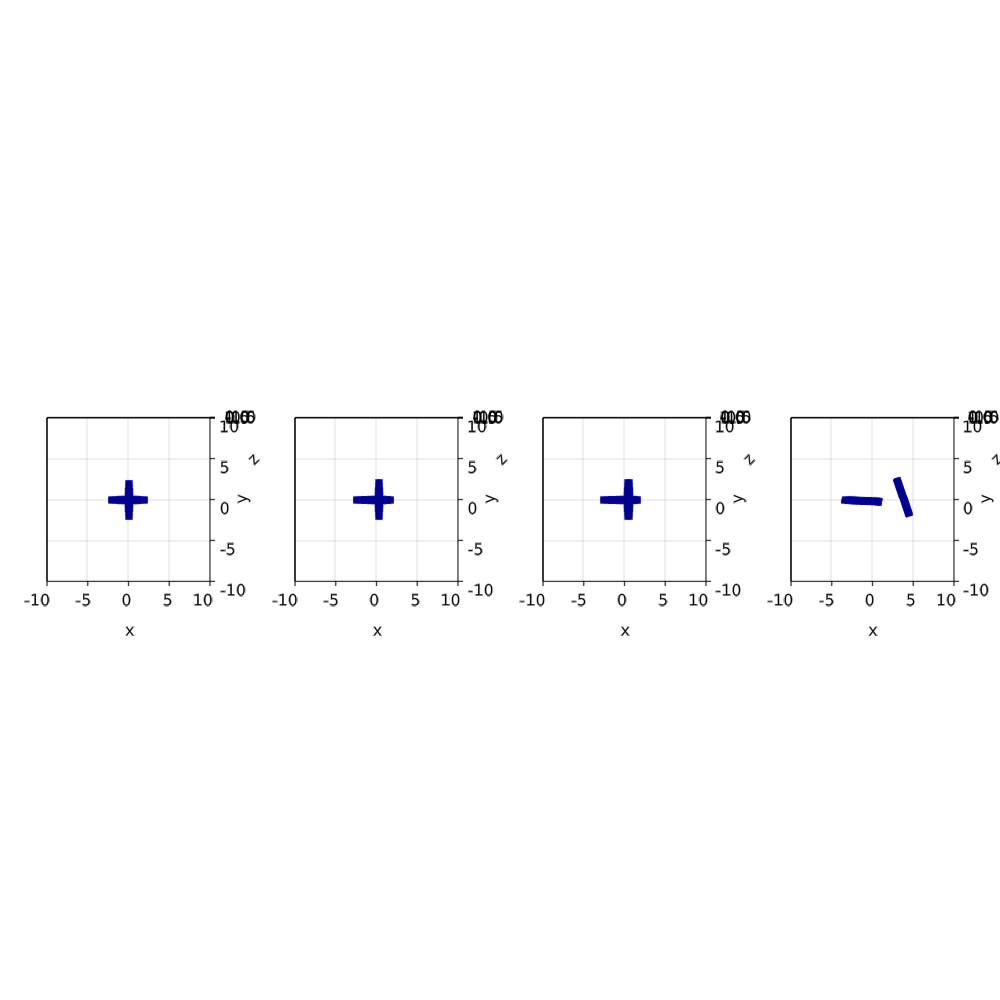

In [201]:
t_list = [1,20,30,10000]

fig = Figure(resolution=(1000,1000))

for (i,t) in enumerate(t_list)
    dir = zeros(comt[1].N,2)
    for i in 1:comt[t].N
        dir[i,1] = cos(comt[t].theta[i])
        dir[i,2] = sin(comt[t].theta[i])
    end
    ax = plotCylinders(fig[1,i],comt[t],dir,:l,:d)

    xlims!(ax,-10,10)
    ylims!(ax,-10,10)
end

fig

## Simulation of many bacteries

In [65]:
com = Community(model,N=1000);

com.kn = 1.
com.γn = 1.
com.γt = 1.
com.μcc = 0.1
com.μcw = 0.8
com.β = 5.
com.βω = 1.

com.m .= 1.
com.d .= 1.
com.l .= 5.;

com.x = rand(Uniform(-20,20),com.N)
com.y = rand(Uniform(-20,20),com.N)
com.theta = rand(Uniform(-π/2,π/2),com.N);

In [73]:
comt = model.evolve(com,dt=0.1,tMax=1000,dtSave=10);

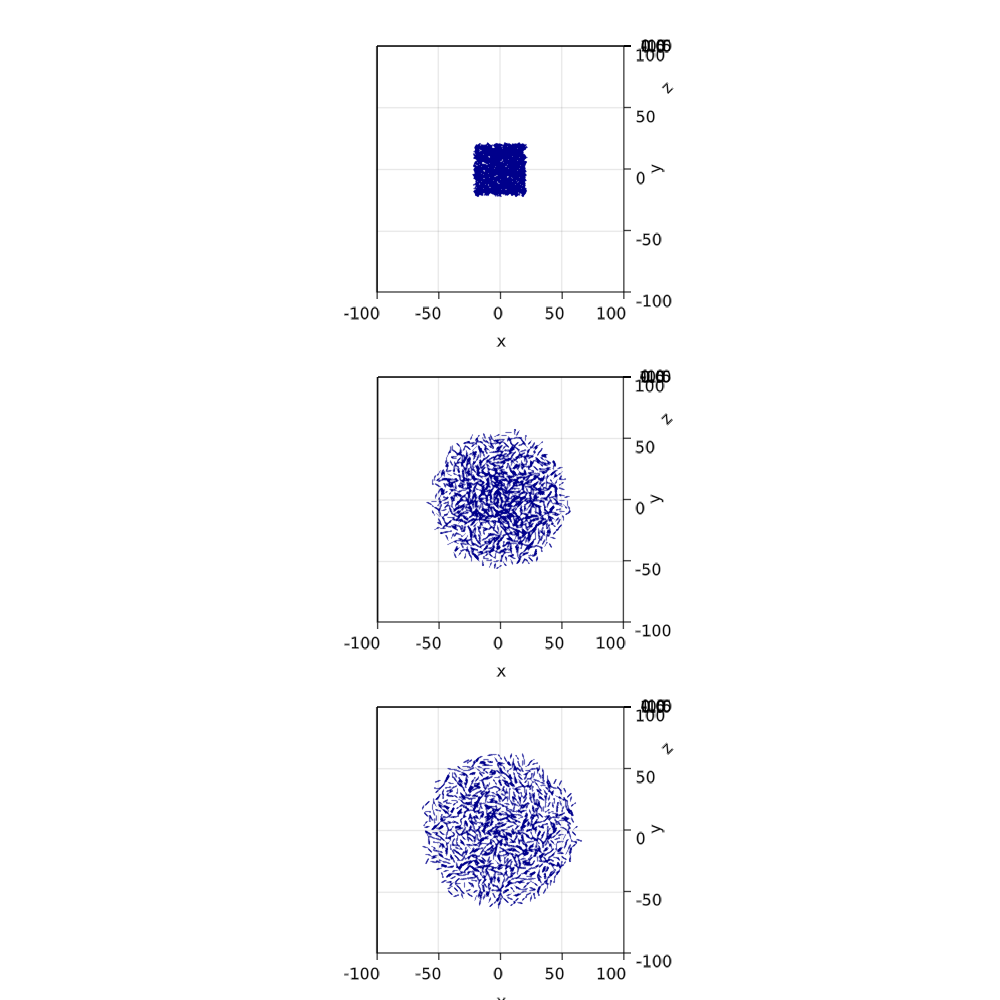

In [75]:
t_list = [1,50,100]

fig = Figure(resolution=(1000,1000))

for (i,t) in enumerate(t_list)
    dir = zeros(comt[1].N,2)
    for i in 1:comt[t].N
        dir[i,1] = cos(comt[t].theta[i])
        dir[i,2] = sin(comt[t].theta[i])
    end
    ax = plotCylinders(fig[i,1],comt[t],dir,:l,:d)

    xlims!(ax,-100,100)
    ylims!(ax,-100,100)
end

fig

In [76]:
save("bacteriesSimulation.png",fig)

GLMakie.Screen(...)

## Benchmark

In [58]:
N_list = [10,100,1000,10000]
t_list = []

for n in N_list

    com = Community(model,N=n);

    com.kn = 1.
    com.γn = 1.
    com.γt = 1.
    com.μcc = 0.1
    com.μcw = 0.8
    com.β = 5.
    com.βω = 1.

    com.m .= 1.
    com.d .= 1.
    com.l .= 5.;

    com.x = rand(Uniform(-n,n),com.N)
    com.y = rand(Uniform(-n,n),com.N)
    com.theta = rand(Uniform(-π/2,π/2),com.N);
    
    t = @benchmark comt = model.evolve(com,dt=0.1,tMax=10,dtSave=1);
    
    push!(t_list,t)
end

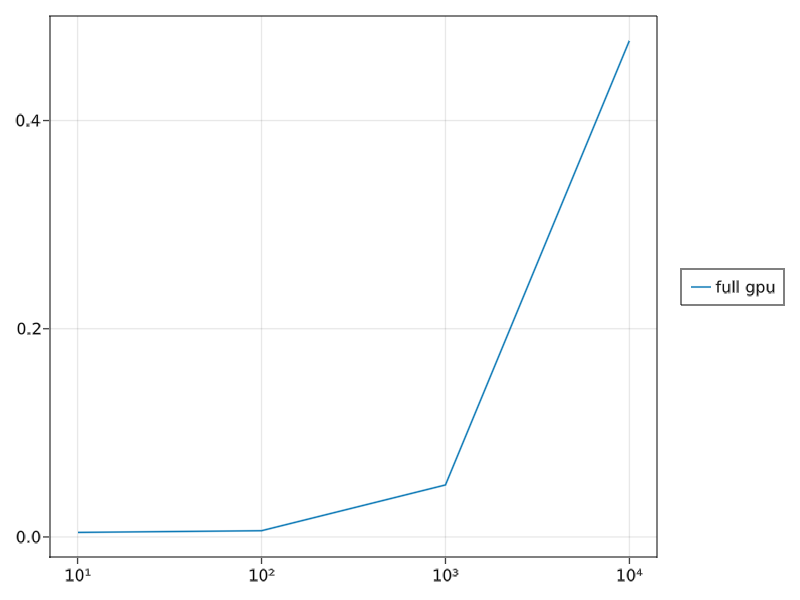

In [59]:
fig = Figure()
ax = Axis(fig[1,1])

object = lines!(ax,N_list,[median(i.times) for i in t_list].*10^-9)

Legend(fig[1,2],[object],["full gpu"])
ax.xscale = log10

fig

In [61]:
save("bacteria.png",fig)

GLMakie.Screen(...)

# Second model: Growth

In [105]:
model = @agent(2,
            [vx,vy,theta,ω,d,l,m,I,Fx,Fy,W]::Local, #Local parameters
            [kn,γn,γt,μcc,μcw,β,βω,growth,lMax]::Global,        #Global parameters
            contact::Identity,

            UpdateInteraction = begin
                #Compute distance between centers of mass
                dAux = sqrt((x.i-x.j)^2+(y.i-y.j)^2)
                if dAux > 0 && dAux < (l.i+l.j)/2
                    if abs(theta.i-theta.j)>0.001 #If not aligned
                        #Compute intersecting point virtual spheres
                        cxAux = (x.i-x.j)
                        cyAux = (y.i-y.j)
                        normAux = cos(theta.i)*sin(theta.j)-sin(theta.i)*cos(theta.j)
                        scaleAux = (-sin(theta.j)*cxAux+cos(theta.j)*cyAux)/normAux
                        pxAux = scaleAux*cos(theta.i)+x.i
                        pyAux = scaleAux*sin(theta.i)+y.i
                        
                        #Compute distance fron mass center
                        di = sqrt((x.i-pxAux)^2+(y.i-pyAux)^2)
                        if di <= l.i/2 #Cross point in cylinder
                            xiAux = 0.999*scaleAux*cos(theta.i)+x.i
                            yiAux = 0.999*scaleAux*sin(theta.i)+y.i
                            scaleAux = (-sin(theta.i)*cxAux+cos(theta.i)*cyAux)/normAux
                            xjAux = 0.999*scaleAux*cos(theta.j)+x.j
                            yjAux = 0.999*scaleAux*sin(theta.j)+y.j
                        else #Cross point outside cylinder
                            xiAux = l.i/2*cos(theta.i)+x.i
                            yiAux = l.i/2*sin(theta.i)+y.i
                            xjAux = l.j/2*cos(theta.j)+x.j
                            yjAux = l.j/2*sin(theta.j)+y.j
                        end
                    else #If aligned
                        xiAux = -0.49*(x.i-x.j)*cos(theta.i)+x.i
                        yiAux = -0.49*(y.i-y.j)*sin(theta.i)+y.i
                        xjAux = -0.49*(x.j-x.i)*cos(theta.j)+x.j
                        yjAux = -0.49*(y.j-y.i)*sin(theta.j)+y.j         
                    end

                    #Compute distance between virtual spheres
                    rij = sqrt((xiAux-xjAux)^2 +(yiAux-yjAux)^2)
                    if rij > 0 && rij < d.i #If it is smaller than a diameter
                        #Compute auxiliar
                        δAux = d.i - rij
                        MeAux = m.i/2
                        #Compute interaction
                        nijx = (xiAux-xjAux)/rij
                        nijy = (yiAux-yjAux)/rij
                        vijx = (vx.i-vx.j)
                        vijy = (vy.i-vy.j)
                        #Compute inner product
                        vnAux = nijx*vijx+nijy*vijy
                        #Compute normal and tangential forces
                        FnAux = kn*δAux^1.5-γn*MeAux*δAux*vnAux
                        FtAux = -min(γt*MeAux*δAux^.5,μcc*FnAux)
                        #Append to interaction forces
                        Fijx = FnAux*nijx + FtAux*(vijx-vnAux*nijx)
                        Fijy = FnAux*nijy + FtAux*(vijy-vnAux*nijx)
                        Fx.i += Fijx
                        Fy.i += Fijy
                        #Append radial forces
                        W.i += (xiAux-x.i)*Fijy - (yiAux-y.i)*Fijx
                    end
                end
            end,

            Equation = begin
                d(x) = vx*dt
                d(y) = vy*dt
                d(vx) = -β*vx*dt+Fx/m*dt
                d(vy) = -β*vy*dt+Fy/m*dt
                d(ω) = W/(m*(d+l)^2/12+m*d^2)*dt-βω*ω*dt
                d(theta) = ω*dt
                d(l) = growth*dt
            end,

            UpdateLocal = begin #Bound cells
                if theta < -π/2
                    theta += π
                elseif theta > π/2
                    theta -= π
                end
        
                #Add division
                if l > lMax && N < 2
                    addAgent(
                            x=l/5*cos(theta)+x,
                            y=l/5*sin(theta)+y,
                            l=l/2,
                            vx = vx,
                            vy = vy,
                            theta = theta+Uniform(-.1,.1),
                            ω = 0,
                            d = d,
                            m = m,
                            I = I,
                            Fx = 0,
                            Fy = 0,
                            W = 0,
                            contact = 1)
                    addAgent(
                            x=-l/5*cos(theta)+x,
                            y=-l/5*sin(theta)+y,
                            l=l/2,
                            vx = vx,
                            vy = vy,
                            theta = theta+Uniform(-.1,.1),
                            ω = 0,
                            d = d,
                            m = m,
                            I = I,
                            Fx = 0,
                            Fy = 0,
                            W = 0,
                            contact = 1)
                    removeAgent()
                end
            end
    );

model = compile(model,integrator="Euler",platform="cpu");
#model.program

In [106]:
com = Community(model,N=1);

com.kn = 1.
com.γn = 1.
com.γt = 1.
com.μcc = 0.1
com.μcw = 0.8
com.β = 1.
com.βω = 5.
com.growth = 0.001
com.lMax = 6

com.m .= 1.
com.d .= 1.
com.l .= 5.;

com.x .= 0
com.y .= 0
com.theta = rand(Uniform(-π/2,π/2),com.N);

In [107]:
comt = model.evolve(com,dt=0.1,nMax=1000,tMax=5000,dtSave=10);

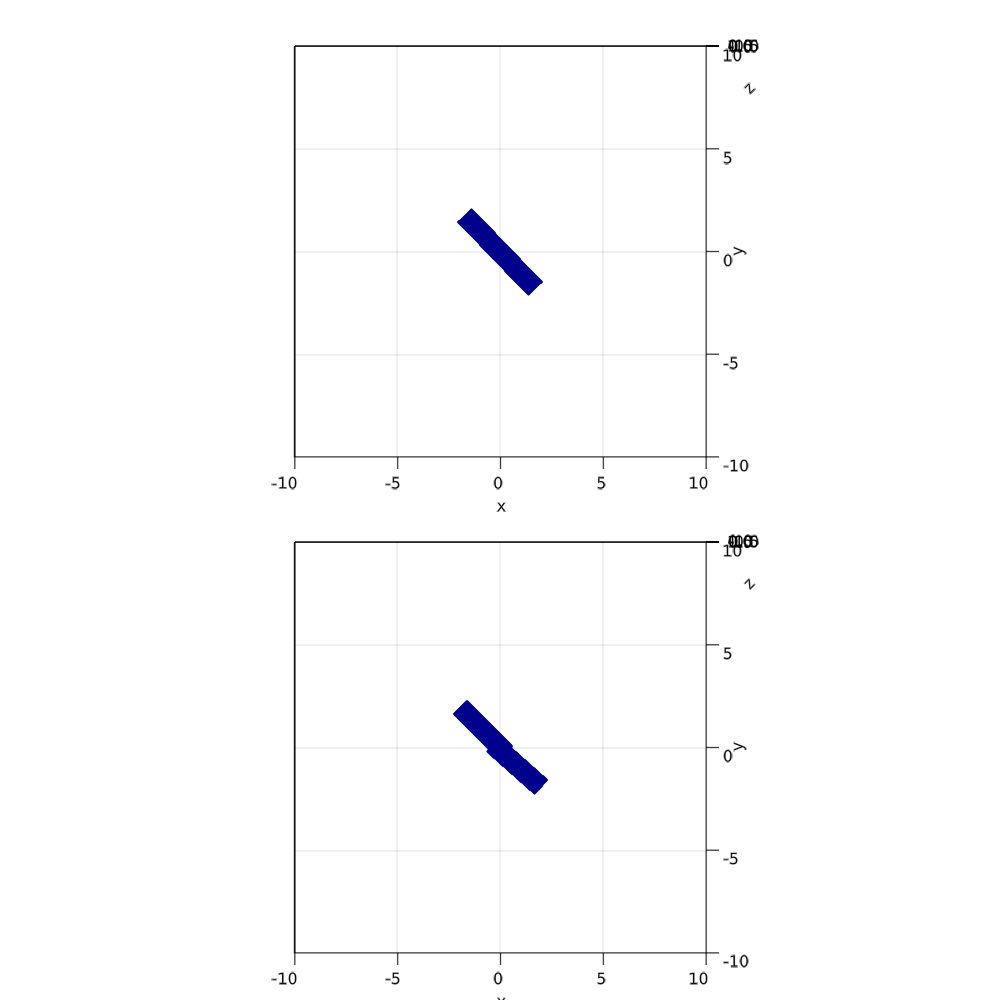

In [110]:
t_list = [1,120]

fig = Figure(resolution=(1000,1000))

for (i,t) in enumerate(t_list)
    dir = zeros(comt[t].N,2)
    for i in 1:comt[t].N
        dir[i,1] = cos(comt[t].theta[i])
        dir[i,2] = sin(comt[t].theta[i])
    end
    ax = plotCylinders(fig[i,1],comt[t],dir,:l,:d)

    xlims!(ax,-10,10)
    ylims!(ax,-10,10)
end

fig

# Third model

In [6]:
model = @agent(2,
            [gₖ,gₗ,C,Vₖ₀,Vₗ₀,δₖ,δₗ,Sₜₕ,Vₜₕ,α₀,β,m,σ,γₛ,αₛ,η,ϵ,βₖ,V₀,αₑ,γₑ,E₀,q,Kₑ,αₖ,βₖ,Dₖ]::Global,  #Global parameters
            [V,n,S,Ki,E]::Local, #Bichemical variables
            [VK,VL,P]::Local,    #Biochemical parameters

            Ke::Medium,

            UpdateLocal = begin
                VK = Vₖ₀+δₖ*(Kₑ+K)       #Resting potential
                VL = Vₗ₀+δₗ*(Kₑ+K)       #Resting potential
                P = Ke^q/((E-E₀)^q+Kₑ^q) #Tumbling dynamics
            end;

            Equation = begin #Eqautions of the chemical
                d_V = (-gₖ*n^4*(V-Vₖ)-gₗ*(V-Vₗ))/(η*C)*dt         #Membrane potential
                d_n = (α₀S^m/(Sₜₕ^m+S^m)*(1-n)-β*n)/η*dt          #Potasium levels
                d_S = (αₛ*(Vₜₕ-V)/(exp((Vₜₕ-V)/σ)-1)-γₛ*S)/η*dt   #Stress
                d_Ki = (-ϵ*gₖ*n^4*(V-Vₖ)+βₖ*max((V₀-V),0))*dt     #Intrecellular potassium
                d_E = (-αₑ*V-γₑ*E)*dt                             #Energy
            end;

            UpdateMedium = begin
                ∂t_Ke = δx(x)+Dₖ*(Δx(Ke)+Δx(Ke)) #Difussion model
            end
)

LoadError: LoadError: UndefVarError: @agent not defined
in expression starting at In[6]:1